# Introduction 
* This code is adapted from the example provided in the python optimal transport package 

This notebook presents the results of mapping a 1D uniform and 2D uniform input distribution to a 2D uniform target distribution on a cylinder embedded in 3D.


## Imports

In [1]:
%matplotlib inline
%matplotlib widget
# import sys
# !{sys.executable} -m pip install pot
# !{sys.executable} -m pip install ipympl 
# !{sys.executable} -m pip install ipywidgets

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
from torch import nn
import ot
import scipy 

use_cuda = torch.cuda.is_available()
if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

seed = 126
torch.manual_seed(seed) # make chunk execution consistent 
np.random.seed(seed) # consistent input grid 

__CUDNN VERSION: 8902
__Number CUDA Devices: 1
__CUDA Device Name: NVIDIA GeForce RTX 4080
__CUDA Device Total Memory [GB]: 16.860184576


## Data generation

In [2]:
torch.manual_seed(seed) # make chunk execution consistent 

sigma = 0.0
n_dims = 3
n_features = 1


def get_data_unif(n_samples):
    # c = torch.rand(size=(n_samples, 2))
    c1 = torch.arange(1, n_samples+1) / (n_samples)# .reshape((n_samples, 1)) / (n_samples)
    c2 = torch.arange(1, n_samples+1) / (n_samples)# .reshape((n_samples, 1)) / (n_samples)
    c = torch.cartesian_prod(c1,c2)
    x = c
    return x


def get_data_unif_3d(n_samples):
    # c = torch.rand(size=(n_samples, 2))
    c1 = torch.arange(1, n_samples+1) / (n_samples)# .reshape((n_samples, 1)) / (n_samples)
    c2 = torch.arange(1, n_samples+1) / (n_samples)# .reshape((n_samples, 1)) / (n_samples)
    c3 = torch.arange(1, n_samples+1) / (n_samples)# .reshape((n_samples, 1)) / (n_samples)
    c = torch.cartesian_prod(c1,c2, c3)
    x = c
    return x

def get_data(n_samples):
    u = torch.rand(size=(n_samples, 1))
    v = torch.rand(size=(n_samples, 1))
    u = u * np.pi
    v = v * 2 * np.pi
    # v = v * np.pi
    r = 1
    x = torch.cat((r*torch.sin(u)*torch.cos(v) , r*torch.sin(u)*torch.sin(v),r*torch.cos(u)), 1)
    # x += torch.randn(n_samples, 2) * sigma
    return x


def sample_surface_cylinder_torch(r, h, n_samples):
    # Points on the side surface
    phi = torch.rand(n_samples) * 2 * np.pi
    z_side = torch.rand(n_samples) * h
    x_side = r * torch.cos(phi)
    y_side = r * torch.sin(phi)
    
    # Combine side, top, and bottom surface points
    x = torch.cat([x_side]).unsqueeze(1)
    y = torch.cat([y_side]).unsqueeze(1)
    z = torch.cat([z_side]).unsqueeze(1)

    out = torch.cat((x, y, z), 1)
    return out

def sample_surface_cylinder_torch_2(r, h, n_samples):
    # sample uniform 
    # u = torch.rand(size=(n_samples, 1))
    # v = torch.rand(size=(n_samples, 1))
    c1 = torch.arange(1, n_samples+1) / (n_samples)# .reshape((n_samples, 1)) / (n_samples)
    c2 = torch.arange(1, n_samples+1) / (n_samples)# .reshape((n_samples, 1)) / (n_samples)
    c = torch.cartesian_prod(c1,c2)

    # convert to cylinder 
    x = r * torch.cos(2 * np.pi * c[:,0])
    y = r * torch.sin(2 * np.pi * c[:,0])
    z = c[:,1]

    out = torch.stack((x,y,z), 1)
    return out

def get_data_cylinder_sobol(n_samples, r=1):
    a = scipy.stats.qmc.Sobol(d=2, scramble=True, optimization='lloyd')
    c = torch.tensor(a.random_base2(m=n_samples)).float()

    # convert to cylinder 
    x = r * torch.cos(2 * np.pi * c[:,0])
    y = r * torch.sin(2 * np.pi * c[:,0])
    z = c[:,1]

    out = torch.stack((x,y,z), 1)
    return out

def get_data_noise_grid_3D(num_samples=10, num_remove=100, verbose=False):

    # Define grid size (perfect cube)
    grid_size = num_samples  # Since 10^3 = 1000

    # Generate grid points
    linspace = np.linspace(0, 1, grid_size)
    X, Y, Z = np.meshgrid(linspace, linspace, linspace)
    points = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T  # Convert grid to (N, 3) array

    # Randomly remove 100 points
    num_to_remove = num_remove
    indices_to_remove = np.random.choice(points.shape[0], num_to_remove, replace=False)
    points = np.delete(points, indices_to_remove, axis=0)

    if verbose: 
        # Print first 5 points as a sample
        print(points[:5])
        print(f"Total points remaining: {points.shape[0]}")  # Should be 900

    return points 

# empirical fill-based loss  
from scipy.spatial.distance import cdist
def fill_distance(data, fitted, type='max'): 
    m = torch.tensor(cdist(data, fitted, 'euclidean')) 
    # m = cdist(data, fitted, 'euclidean')
    min, min_indices = torch.min(m, dim=1) # min across rows 
    if type=='max':
        fill_dist = max(min)
    elif type=='mean':
        fill_dist = torch.mean(min)
    else:
        fill_dist = max(min)

    return fill_dist.item() # get actual float 


## Plot data



torch.Size([900, 3])


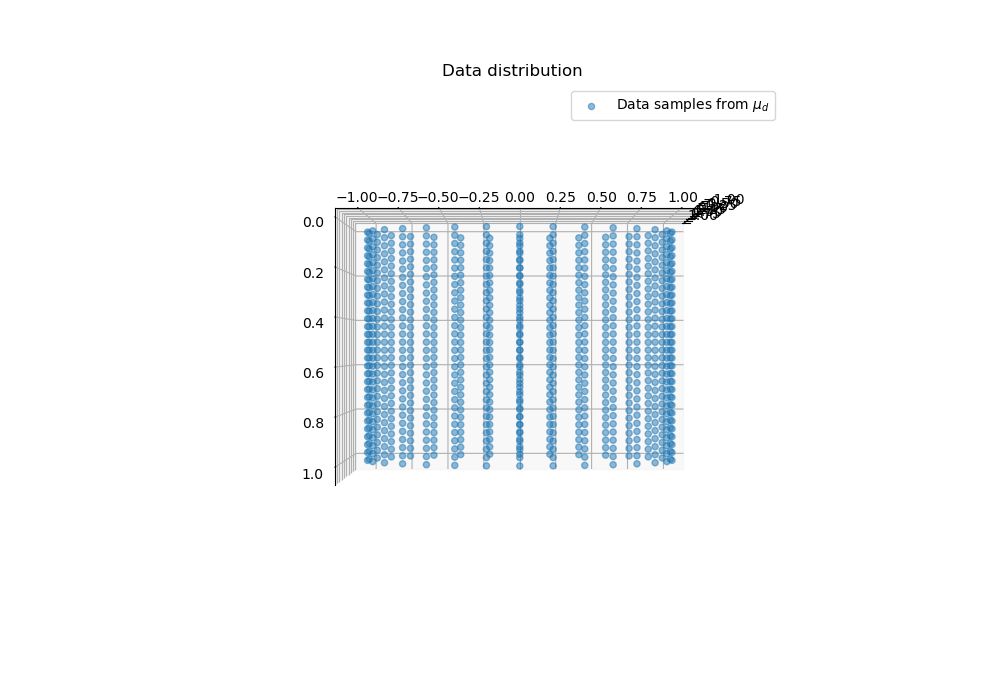

In [3]:
torch.manual_seed(seed) # make chunk execution consistent 

from mpl_toolkits import mplot3d

# plot the distributions
x =  sample_surface_cylinder_torch_2(r=1, h=1, n_samples=30)
# x = get_data_cylinder_sobol(n_samples=10, r=1)
print(x.shape)

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

# Creating plot
plt.title("simple 3D scatter plot")
ax.scatter3D(x[:, 0], x[:, 1], x[:, 2], label='Data samples from $\mu_d$', alpha=0.5)
plt.title('Data distribution')
plt.legend()

ax.view_init(-180, 0)


## 3D to 2D

In [4]:
torch.manual_seed(seed) # make chunk execution consistent 

class Generator_3D_2D(torch.nn.Module):
    def __init__(self):
        super(Generator_3D_2D, self).__init__()
        self.n_features = 3
        self.n_out = 3
        leaky = 0.0001
        w_layer = 20
        self.model = nn.Sequential( 
            nn.Linear(self.n_features, w_layer),
            nn.LeakyReLU(leaky),
            nn.Linear(w_layer, w_layer),
        )
        
        for i in range(0,1): # was 1 
            temp = nn.Sequential(
                nn.Linear(w_layer, w_layer),
                nn.LeakyReLU(leaky),
            )
            self.model.append(temp)
            
        self.model.append(nn.Linear(w_layer, self.n_out))
        
    def forward(self, x):
        x = self.model(x)
        return x
    

g2 = Generator_3D_2D()
num_hidden_layers = sum(1 for _ in g2.modules() if isinstance(_, nn.Linear))-1
print(f"The number of hidden layers in G2 is: {num_hidden_layers}")


The number of hidden layers in G2 is: 3


Iter: 0, 	 wass-loss=1.19004, 	 fill-dist=1.06143
Iter: 10, 	 wass-loss=1.03568, 	 fill-dist=0.9795
Iter: 20, 	 wass-loss=0.94952, 	 fill-dist=0.93205
Iter: 30, 	 wass-loss=0.87992, 	 fill-dist=0.88849
Iter: 40, 	 wass-loss=0.82565, 	 fill-dist=0.85079
Iter: 50, 	 wass-loss=0.78222, 	 fill-dist=0.81752
Iter: 60, 	 wass-loss=0.74173, 	 fill-dist=0.78512
Iter: 70, 	 wass-loss=0.7012, 	 fill-dist=0.75237
Iter: 80, 	 wass-loss=0.66113, 	 fill-dist=0.7196
Iter: 90, 	 wass-loss=0.62168, 	 fill-dist=0.68643
Iter: 100, 	 wass-loss=0.57947, 	 fill-dist=0.65067
Iter: 110, 	 wass-loss=0.53806, 	 fill-dist=0.6157
Iter: 120, 	 wass-loss=0.49882, 	 fill-dist=0.58189
Iter: 130, 	 wass-loss=0.46312, 	 fill-dist=0.54938
Iter: 140, 	 wass-loss=0.43176, 	 fill-dist=0.51845
Iter: 150, 	 wass-loss=0.40457, 	 fill-dist=0.49046
Iter: 160, 	 wass-loss=0.38099, 	 fill-dist=0.46433
Iter: 170, 	 wass-loss=0.36027, 	 fill-dist=0.44124
Iter: 180, 	 wass-loss=0.34212, 	 fill-dist=0.4183
Iter: 190, 	 wass-loss=0.325

Text(0.5, 0, 'Iterations')

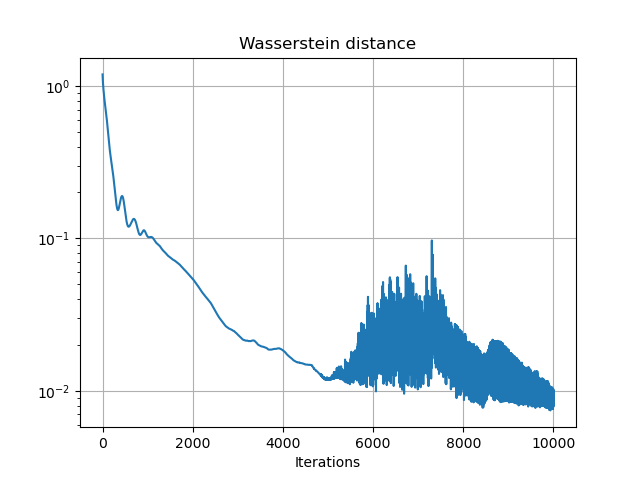

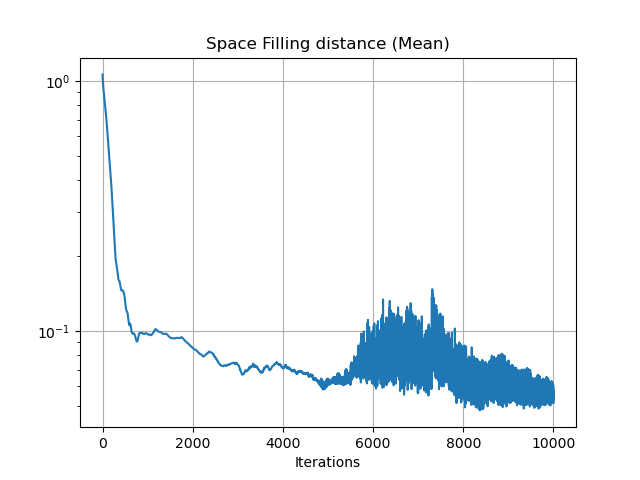

In [5]:
torch.manual_seed(seed) # make chunk execution consistent 
n_features=3

G = Generator_3D_2D()
optimizer = torch.optim.RMSprop(G.parameters(), lr=0.00019, eps=1e-5,  weight_decay=1e-4)

# number of iteration and size of the batches
n_iter = 10000
size_batch = 30
n_features = 3

# generate static samples to see their trajectory along training
# n_visu = 2000
n_visu = size_batch**2
xnvisu = torch.rand(n_visu, n_features)
xvisu = torch.zeros(n_iter, n_visu, n_dims)
# ab = torch.ones(size_batch**2) / size_batch**2
ab = torch.ones(size_batch**2) / size_batch**2

losses = []
fill_losses = []

# generate data samples
xd =  sample_surface_cylinder_torch_2(r=1, h=1, n_samples=size_batch)

# generate noise grid
xn = torch.tensor(get_data_noise_grid_3D(num_samples=10, num_remove=100, verbose=False), dtype=torch.float32) # noise sample 

for i in range(n_iter):

    # generate noise samples
    # xn = torch.rand(size_batch**2, n_features)

    # generate sample along iterations
    xvisu[i, :, :] = G(xnvisu).detach()

    # generate samples and compute distance matrix
    xg = G(xn)
    
    M = ot.dist(xg, xd)
    loss = ot.emd2(ab, ab, M)
    losses.append(float(loss.detach()))

    fill_loss = fill_distance(xd.detach().numpy(), xg.detach().numpy(), type='mean')
    fill_losses.append(fill_loss)

    if i % 10 == 0:
        print(f"Iter: {i}, \t wass-loss={round(losses[-1], 5)}, \t fill-dist={round(fill_loss, 5)}")

    loss.backward()
    optimizer.step()

    del M

# wasserstein loss 
plt.figure(2)
plt.semilogy(losses)
plt.grid()
plt.title('Wasserstein distance')
plt.xlabel("Iterations")

# fill distance 
plt.figure(3)
plt.semilogy(fill_losses)
plt.grid()
plt.title('Space Filling distance (Mean)')
plt.xlabel("Iterations")


Text(0.5, 0, 'Iterations')

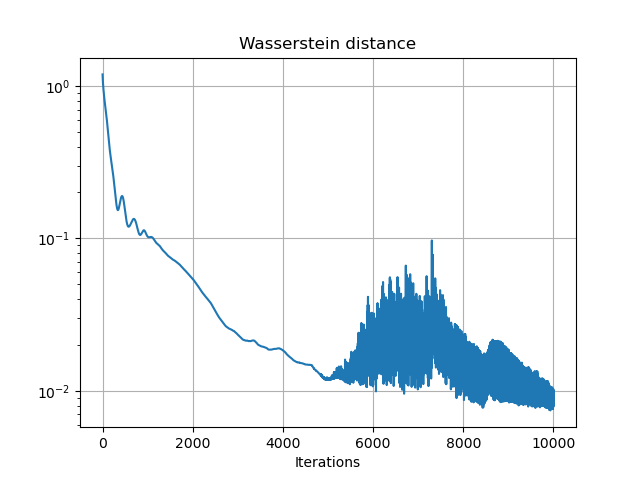

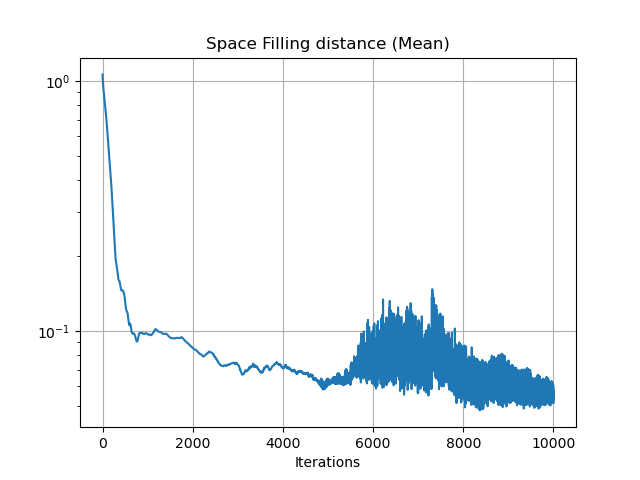

In [18]:

# wasserstein loss 
plt.figure(2)
plt.semilogy(losses)
plt.grid()
plt.title('Wasserstein distance')
plt.xlabel("Iterations")

# fill distance 
plt.figure(3)
plt.semilogy(fill_losses)
plt.grid()
plt.title('Space Filling distance (Mean)')
plt.xlabel("Iterations")


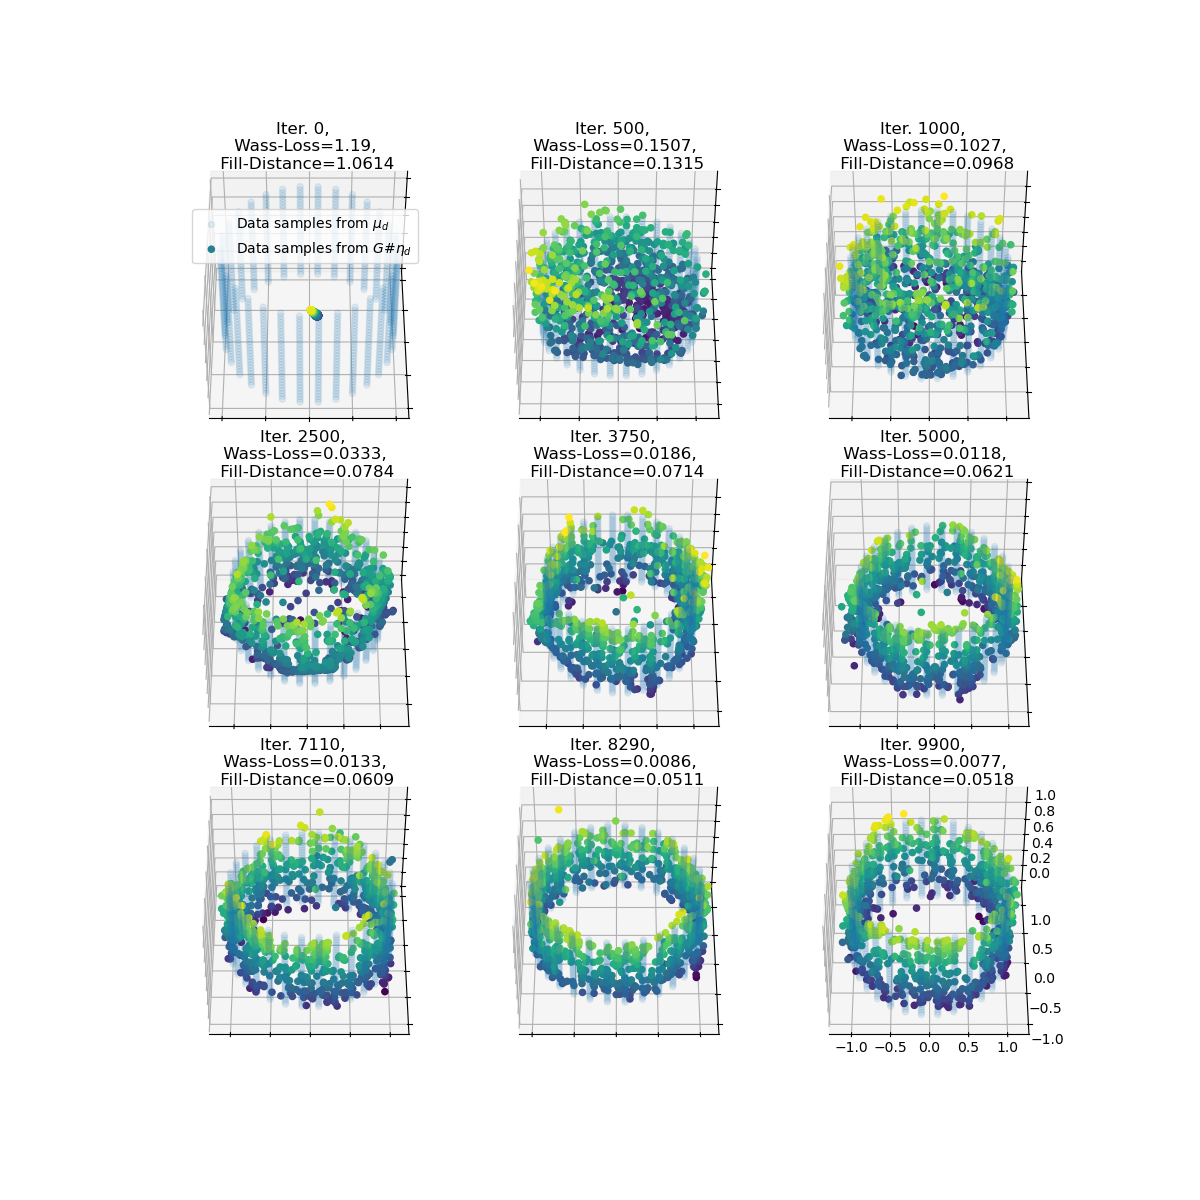

In [17]:
torch.manual_seed(seed) # make chunk execution consistent 

plt.clf()
plt.close('all')
ivisu = [0, 500, 1000, 2500, 3750, 5000, 7110, 8290, 9900]

# create a figure and a 3x3 subplot grid
fig, axs = plt.subplots(3, 3, figsize=(12, 12), subplot_kw={'projection': '3d'}, edgecolor='none')
# fig.tight_layout(pad=1.0)

# iterate over each subplot to convert it into 3D and plot 
for i, ax in enumerate(axs.flat):

    # convert subplot to 3D ---> no need, alr defined above 
        # ax = fig.add_subplot(3, 3, i+1, projection= '3d')

    # adjust the spacing between plots
    plt.subplots_adjust(wspace=-.3, hspace=-.1)
    
    # plot the data
    ax.scatter3D(xd[:, 0], xd[:, 1], xd[:, 2], label='Data samples from $\mu_d$', alpha=0.1)

    # calculate the distance of each point from the origin (0, 0)
    distances = xvisu[ivisu[i], :, 2]
    colors = distances  # use the distances to map to colors

    ax.scatter3D(xvisu[ivisu[i], :, 0], xvisu[ivisu[i], :, 1], xvisu[ivisu[i], :, 2],
                 label='Data samples from $G\#\eta_d$', 
                 alpha=1,
                 c = distances, 
                 cmap = 'viridis'
                 )
    
    # set the view 
    ax.view_init(48, -90, 0) # 44, -90, 0

    # set titles and labels, see issue https://github.com/matplotlib/matplotlib/issues/16805/
    ax.set_title(f'Iter. {ivisu[i]}, \n Wass-Loss={round(losses[ivisu[i]], 4)}, \n Fill-Distance={round(fill_losses[ivisu[i]], 4)}', pad=0, y=1.000001) # need the 1.00001 to turn off auto 
        #ax.set_xlabel('X axis')
        #ax.set_ylabel('Y axis')
        #ax.set_zlabel('Z axis')
    if i == 0:
        ax.legend(bbox_to_anchor=(.5, .7), loc='center', borderaxespad=0) # bbox in coordinates 
    
     # hide the axis ticks
    if (i != 8): # only keep labels on third figure of each row 
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
    if (i == 8): # readjust x axis to be closer 
        ax.xaxis.set_tick_params(pad=-5)
    
    # adjust the visibility of the axes spines
        #ax.spines['top'].set_visible(False)
        #ax.spines['right'].set_visible(False)

# adjust the spacing
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.0)
plt.show()

